# Modeling Notebook - Positive/Negative Classifier

In [1]:
# Import the required libraries
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize, FreqDist
from nltk.tokenize import TweetTokenizer
import string
import wordcloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import plot_confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
from PIL import Image
from os import path

import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns

np.random.seed(42)


In [59]:
#  Function Definitions 

def get_eng_stopwords_list():
    # Get English stopwords, punctuation, and 'empty text' signifiers (like empty quotes and ...)
    return stopwords.words('english')  + list(string.punctuation) + ["''", '""', '...', '``']

def get_social_media_stopwords_list():
    return stopwords.words('english') + ['rt', 'link', '&'] + list(string.punctuation) + ["''", '""', '..', '...', '``']

def tokenize_tweet(tweet):
    tweet_tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
    tokens = tweet_tokenizer.tokenize(tweet)
    #TODO: any stemming you might want to do
    return tokens

def process_tweet_text_encode_to_ascii(tweet, stopwords_list):
    #tokenize, lowercase each token, remove stopwords
    stopwords_removed = ''
    tweet_tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
    try:
        tweet_encode = tweet.encode("ascii", "ignore")
        tweet_decode = tweet_encode.decode()
        tokens = tweet_tokenizer.tokenize(tweet_decode)
        #print(tokens)
        stopwords_removed = [token for token in tokens if token not in stopwords_list]
    except:
        print('Could not encode/decode ', tweet )
    return stopwords_removed

def plot_word_cloud(text, word_max, stopwords_list, bg_color='black'):
    cloud = wordcloud.WordCloud(background_color=bg_color, 
                            min_word_length=2,
                            max_words=word_max)
    cloud.generate(text)
    
    # plot it
    plt.figure(figsize=(15,10))
    plt.imshow(cloud, interpolation='bilinear') 
    plt.axis("off")
    plt.show()


#TODO: figure out why this is not working to apply the image as mask
def plot_word_cloud_with_mask(text, word_max, stopwords_list, bg_color='black'):
    # get data directory (using getcwd() is needed to support running example in generated IPython notebook)
    d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()
    twitter_mask = np.array(Image.open('../images/twitter.png'))
    cloud = wordcloud.WordCloud(background_color=bg_color, 
                            min_word_length=2,
                            mask=twitter_mask,
                            contour_width=3, 
                            contour_color='steelblue',
                            max_words=word_max)
    cloud.generate(text)

    # store to file
    cloud.to_file(path.join(d, "twitter_cloud.png"))

    # plot it
    #plt.figure(figsize=(15,10))
    plt.imshow(cloud, interpolation='bilinear') 
    plt.axis("off")
    plt.imshow(twitter_mask, cmap=plt.cm.gray, interpolation='bilinear')
    plt.axis("off")
    plt.show()


def plot_pretty_cf(predictor, xtest, ytest, cmap='Blues', normalize='true', title=None):
    fig, ax = plt.subplots(figsize=(8, 8))
    plot_confusion_matrix(predictor, xtest, ytest, cmap=cmap, normalize=normalize, ax=ax)
    ax.set_title(title, size='large')
    ax.set_xlabel('Predicted Label', size='medium')
    ax.set_ylabel('True Label', size='medium')
    plt.show()



In [60]:
# read in the processed data
pos_tweets = pd.read_csv('../data/cleaned_tweets_positive.csv', encoding = 'unicode_escape')
print(pos_tweets.shape)

neg_tweets = pd.read_csv('../data/cleaned_tweets_negative.csv', encoding = 'unicode_escape')
print(neg_tweets.shape)

neutral_tweets = pd.read_csv('../data/cleaned_tweets_neutral.csv', encoding = 'unicode_escape')
print(neutral_tweets.shape)

all_tweets = pd.read_csv('../data/cleaned_tweets_all.csv', encoding='unicode_escape')
print(all_tweets.shape)

(2861, 7)
(544, 7)
(5293, 7)
(8698, 7)


## Corpus Exploration
* What are the most common words found in Positive, Negative and Neutral Tweets?

In [61]:
# Create word clouds of the most common words in Positive, Negative (and Neutral) Tweets

positive_tweet_words = list()
for tweet in pos_tweets['tweet_text'].to_list():
    processed_tweet = process_tweet_text_encode_to_ascii(tweet, get_social_media_stopwords_list())
    for word in processed_tweet:
        positive_tweet_words.append(word)

negative_tweet_words = list()
for tweet in neg_tweets['tweet_text'].to_list():
    processed_tweet = process_tweet_text_encode_to_ascii(tweet, get_social_media_stopwords_list())
    for word in processed_tweet:
        negative_tweet_words.append(word)

neutral_tweet_words = list()
for tweet in neutral_tweets['tweet_text'].to_list():
    processed_tweet = process_tweet_text_encode_to_ascii(tweet, get_social_media_stopwords_list())
    for word in processed_tweet:
        neutral_tweet_words.append(word)


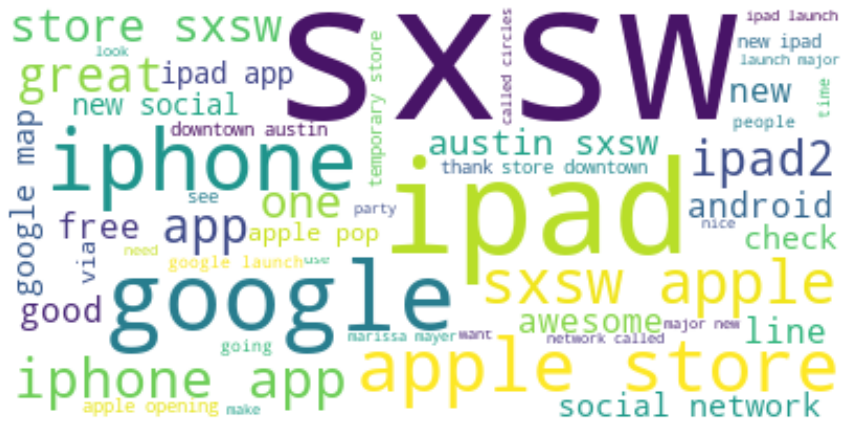

In [62]:
# Postive Tweets top 50 words
positive_text = ' '.join(word for word in positive_tweet_words)
plot_word_cloud(positive_text, 50, get_social_media_stopwords_list(), 'white')

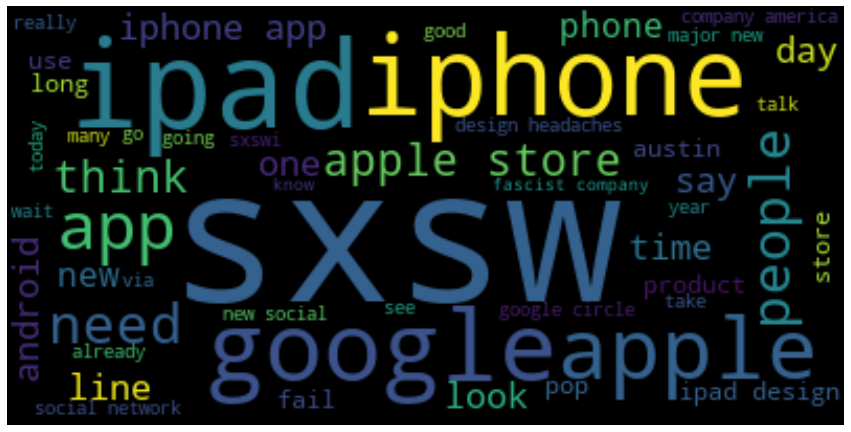

In [63]:
# Negative Tweets top 50 words
negative_text = ' '.join(word for word in negative_tweet_words)
plot_word_cloud(negative_text, 50, get_social_media_stopwords_list())

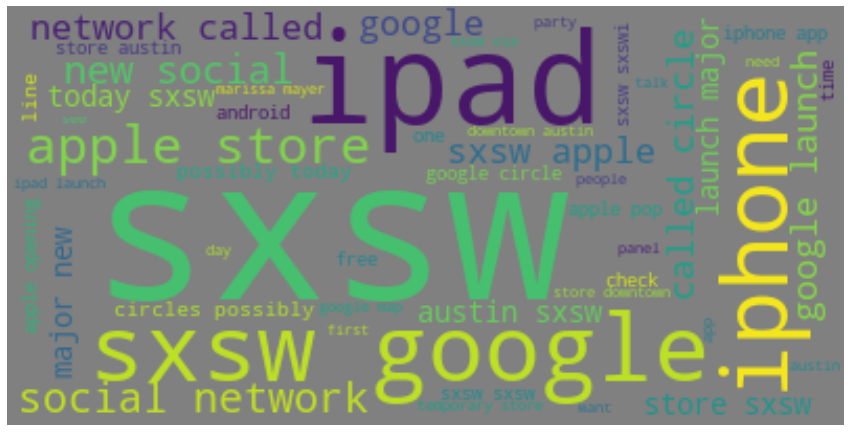

In [64]:
# Neutral Tweets top 50 words
neutral_text = ' '.join(word for word in neutral_tweet_words)
plot_word_cloud(neutral_text, 50, get_social_media_stopwords_list(), 'grey')

## Text Processing for Classification Model

In [65]:
##
# - Create TRAIN and TEST data sets from the Postive and Negative Tweet datasets.
# - Separate the data (tweet_text) and the labels (sentiment) in both TRAIN and TEST
# - Process the TRAIN tweets
# - Explore TRAIN data with Freq Dist
# - Vectorize TRAIN with sklearn
# - Create a basic model (try MultinomialNB and RandomForestClassifier )
# - Fit each to our vectorized training data
# - Create predictions for TRAIN and TEST sets
# - Calculate the accuracy_score() for both TRAIN and TEST 
# - Experiment with model tuning AND/OR other model choices
#
# TODO decide the best peformance measure, accuracy or precision. What makes sense from a business POV?

In [84]:
# Get TRAIN and TEST data and target and prep for processing steps
corpus = all_tweets[all_tweets['sentiment'] != 'Neutral']['tweet_text'].tolist()  #Binary classifier: Pos/Neg
labels = all_tweets[all_tweets['sentiment'] != 'Neutral']['sentiment'].tolist()
train_tweets, test_tweets, train_sentiment, test_sentiment = train_test_split(corpus, labels, test_size=0.3, random_state=42)

In [89]:
# Text Processing - TF-IDF
# Use TF_IDF to focus on words that appear heavily in tweets from a given class, but rarely appear in tweets from other class/classes.

# noticed the #sxsw hastag was in all categories very often, add it to stopwords
custom_stopwords = get_social_media_stopwords_list() + ['#sxsw', 'sxsw', '##sxsw']

from sklearn.feature_extraction.text import TfidfVectorizer

# Use tokenzer for tweets and the customized stopwords list
vectorizer = TfidfVectorizer(tokenizer=tokenize_tweet, stop_words=custom_stopwords, decode_error='ignore')

# Fit on TRAIN data
tf_idf_data_train = vectorizer.fit_transform(train_tweets)
# Creat a vectorized version of the TEST data
tf_idf_data_test = vectorizer.transform(test_tweets)

In [91]:
# TF-IDF - Let's see which terms were important
idf = vectorizer.idf_

feature_weights_dict = dict(zip(vectorizer.get_feature_names(), idf))

sorted_idf = sorted(feature_weights_dict.items(), key=lambda x: x[1], reverse=True)

print(sorted_idf[0:50])

[('#10', 8.083387847625296), ('#100tc', 8.083387847625296), ('#106', 8.083387847625296), ('#11ntc', 8.083387847625296), ('#15slides', 8.083387847625296), ('#16162', 8.083387847625296), ('#1990style', 8.083387847625296), ('#310409h2011', 8.083387847625296), ('#4sq', 8.083387847625296), ("#4sq's", 8.083387847625296), ('#4sq3', 8.083387847625296), ('#aapl', 8.083387847625296), ('#abacus', 8.083387847625296), ('#accessibility', 8.083387847625296), ('#accordion', 8.083387847625296), ('#aclu', 8.083387847625296), ('#actors', 8.083387847625296), ('#adam', 8.083387847625296), ('#addictedtotheinterwebs', 8.083387847625296), ('#adpeopleproblems', 8.083387847625296), ('#agnerd', 8.083387847625296), ('#allhat3', 8.083387847625296), ('#alwayshavingtoplugin', 8.083387847625296), ('#amex', 8.083387847625296), ('#amismarternow', 8.083387847625296), ('#angrybirds', 8.083387847625296), ('#annoying', 8.083387847625296), ('#anybodywanttobuymeanipad2', 8.083387847625296), ('#appcircus', 8.083387847625296),

In [92]:
# Model creation
# create some models and fit them to our vectorized training data
nb_classifier = MultinomialNB()
rf_classifier = RandomForestClassifier(n_estimators=100)

In [93]:
nb_classifier.fit(tf_idf_data_train, train_sentiment)
nb_train_preds = nb_classifier.predict(tf_idf_data_train)
nb_test_preds = nb_classifier.predict(tf_idf_data_test)

In [94]:
nb_train_score = accuracy_score(train_sentiment, nb_train_preds)
nb_test_score = accuracy_score(test_sentiment, nb_test_preds)
print("Multinomial Naive Bayes")
print("Training Accuracy: {:.4} \t\t Testing Accuracy: {:.4}".format(nb_train_score, nb_test_score))

Multinomial Naive Bayes
Training Accuracy: 0.8519 		 Testing Accuracy: 0.8659


In [95]:
print(classification_report(test_sentiment, nb_test_preds, target_names=['Negative', 'Positive']))

              precision    recall  f1-score   support

    Negative       1.00      0.04      0.08       143
    Positive       0.87      1.00      0.93       879

    accuracy                           0.87      1022
   macro avg       0.93      0.52      0.50      1022
weighted avg       0.88      0.87      0.81      1022



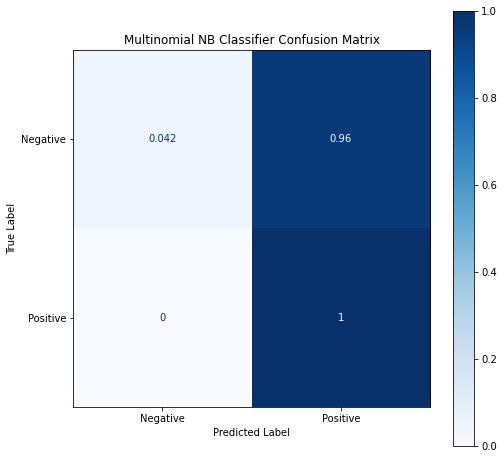

In [96]:
plot_pretty_cf(nb_classifier, tf_idf_data_test, test_sentiment, title='Multinomial NB Classifier Confusion Matrix')

In [97]:
rf_classifier.fit(tf_idf_data_train, train_sentiment)
rf_train_preds = rf_classifier.predict(tf_idf_data_train)
rf_test_preds = rf_classifier.predict(tf_idf_data_test)

In [98]:
rf_train_score = accuracy_score(train_sentiment, rf_train_preds)
rf_test_score = accuracy_score(test_sentiment, rf_test_preds)
print('Random Forest')
print("Training Accuracy: {:.4} \t\t Testing Accuracy: {:.4}".format(rf_train_score, rf_test_score))

Random Forest
Training Accuracy: 0.9983 		 Testing Accuracy: 0.8875


In [99]:
print(classification_report(test_sentiment, rf_test_preds, target_names=['Negative', 'Positive']))

              precision    recall  f1-score   support

    Negative       0.82      0.25      0.39       143
    Positive       0.89      0.99      0.94       879

    accuracy                           0.89      1022
   macro avg       0.85      0.62      0.66      1022
weighted avg       0.88      0.89      0.86      1022



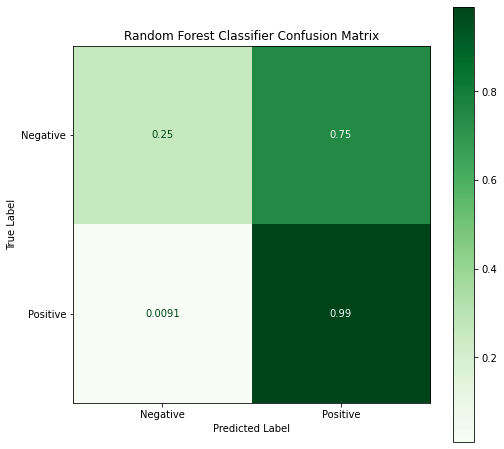

In [100]:
plot_pretty_cf(rf_classifier, tf_idf_data_test, test_sentiment, cmap='Greens', title='Random Forest Classifier Confusion Matrix')

### Random Forest was better than NB...but still pretty crummy due to a high number of False Negatives: incorrectly classifed a Negative sentiment tweet as a Positive sentitment tween. Also, there is MASSIVE overfitting.